# LGBM Classifier- Vanilla CPU

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
import parselmouth
from tqdm import tqdm
from scipy.stats import entropy
from scipy.signal import find_peaks

In [2]:
# Now reading the CSV
df = pd.read_csv('dysnet.csv')
df.head(5)

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std,label
0,-311.38477,26.980896,-9.236873,-3.446952,2.797759,-13.794222,-8.201365,-2.554216,-8.087993,-5.623301,...,8.679014,0.019937,0.152964,-135.471046,6536.470588,1,0.064000,0.016381,0.015243,0
1,-320.63364,31.162016,2.956488,9.534509,12.790990,-16.227764,-0.710162,-4.909526,-18.544220,2.431236,...,8.882021,0.017777,0.126177,-129.239224,5356.881720,15,0.241067,0.022353,0.021942,0
2,-300.99728,41.158607,-7.435174,7.761700,17.381987,-22.159197,-3.731641,-0.665727,-20.164322,-0.539192,...,8.686836,0.018722,0.109250,-113.387997,4946.394558,14,0.077714,0.025352,0.021311,0
3,-420.62094,-9.740299,35.861446,-1.680403,10.240573,-1.752196,1.488229,8.667743,-3.011296,0.726974,...,8.285378,0.096660,0.193904,-141.658091,9243.238095,0,0.000000,0.003137,0.002628,0
4,-288.11353,60.211166,10.757963,16.713995,21.329540,-10.454901,2.528886,-1.848374,-13.347257,7.410037,...,7.590672,0.041010,0.126378,-77.018103,2185.376344,0,0.000000,0.026444,0.014165,0


In [3]:
# check for null values
df.isnull().sum()

mfcc_0                 0
mfcc_1                 0
mfcc_2                 0
mfcc_3                 0
mfcc_4                 0
mfcc_5                 0
mfcc_6                 0
mfcc_7                 0
mfcc_8                 0
mfcc_9                 0
mfcc_10                0
mfcc_11                0
mfcc_12                0
delta_mfcc_0           0
delta_mfcc_1           0
delta_mfcc_2           0
delta_mfcc_3           0
delta_mfcc_4           0
delta_mfcc_5           0
delta_mfcc_6           0
delta_mfcc_7           0
delta_mfcc_8           0
delta_mfcc_9           0
delta_mfcc_10          0
delta_mfcc_11          0
delta_mfcc_12          0
delta2_mfcc_0          0
delta2_mfcc_1          0
delta2_mfcc_2          0
delta2_mfcc_3          0
delta2_mfcc_4          0
delta2_mfcc_5          0
delta2_mfcc_6          0
delta2_mfcc_7          0
delta2_mfcc_8          0
delta2_mfcc_9          0
delta2_mfcc_10         0
delta2_mfcc_11         0
delta2_mfcc_12         0
pitch_mean             0


In [4]:
# drop all the rows with missing values
df.dropna(inplace=True)

In [18]:
df.to_csv('dysnet.csv', index=False)

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import joblib
import numpy as np

X = df.drop('label', axis=1)
y = df['label']

# Get number of classes
num_classes = len(np.unique(y))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LGBMClassifier(
        random_state=42,
        objective='multiclass',
        num_class=num_classes
    ))
])

# Define parameter grid
param_grid = {
    'classifier__num_leaves': [31, 63],
    'classifier__max_depth': [5, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200],
    'classifier__min_child_samples': [20]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=3,
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid_search.fit(X_train, y_train)

# Save the best model
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'LGBM.pkl')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12526
[LightGBM] [Info] Number of data points in the train set: 102756, number of used features: 50
[LightGBM] [Info] Start training from score -0.685488
[LightGBM] [Info] Start training from score -0.700865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

['LGBM.pkl']

In [7]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     16180
           1       0.97      0.96      0.96     15932

    accuracy                           0.96     32112
   macro avg       0.96      0.96      0.96     32112
weighted avg       0.96      0.96      0.96     32112

[[15666   514]
 [  675 15257]]


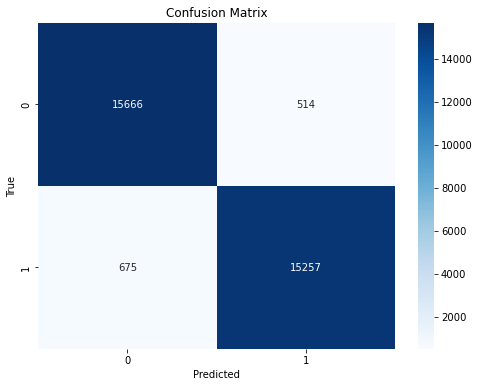

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [8]:
# plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# Function to predict on new data
def predict_dysarthria(features):
    model = joblib.load('GNB.pkl')
    prediction = model.predict(features)
    return prediction

# Example of using the model with dummy data
def create_dummy_data(n_samples=1):
    feature_means = X.mean()
    feature_stds = X.std()
    dummy_data = pd.DataFrame(
        {col: np.random.normal(mean, std, n_samples) 
         for col, mean, std in zip(X.columns, feature_means, feature_stds)}
    )
    return dummy_data

# Test prediction with dummy data
dummy_data = create_dummy_data(5)
predictions = predict_dysarthria(dummy_data)

In [10]:
dummy_data

,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,...,pitch_std,ppe,jitter,shimmer,hnr_mean,speech_rate,pause_count,pause_duration_mean,rms_mean,rms_std
0,-433.946464,20.861411,5.138713,-13.335735,1.804846,-16.708427,3.504041,1.094427,-1.647155,-3.804718,...,1295.934143,6.492922,0.012291,0.143224,-123.012474,1993.714572,-0.977705,0.801871,0.048180,0.074379
1,-309.293555,54.251638,44.703348,-5.649899,-17.651732,3.474004,-19.513599,8.498598,-4.741670,-8.822546,...,1008.483357,7.257658,0.037364,0.073386,-116.032565,3156.815698,0.201090,-0.002855,-0.028201,0.043207
2,-249.657184,72.137956,14.142308,26.656479,-2.438895,-4.941164,-10.632994,5.619996,-8.580330,-2.348403,...,675.934181,6.988869,0.030044,0.128196,-150.751977,5277.535810,3.698216,0.514480,0.035111,0.096258
3,-392.232211,59.551020,18.027728,5.327315,-7.844122,2.065433,-21.329763,-1.719169,-12.247422,-3.271839,...,1089.662273,6.519696,0.048076,0.116687,-148.083927,3975.363491,-0.567036,0.399210,0.051719,0.062160
4,-414.771226,85.193801,-2.333070,-4.871556,5.311166,-9.018884,-27.372681,0.944129,8.221824,7.432670,...,1009.466890,6.905064,0.013924,0.132867,-175.951699,2653.792057,3.066666,0.055985,0.075942,0.097793


In [11]:
predictions

array([0, 0, 0, 0, 0])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.329643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12527
[LightGBM] [Info] Number of data points in the train set: 102756, number of used features: 50
[LightGBM] [Info] Start training from score -0.685508
[LightGBM] [Info] Start training from score -0.700845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [